# CorEx

Example on S\&P500 components data.  
Original version of CorEx from ... and CorEx based on PyTorch (version 1.8.0) is tested. 

In [1]:
# Standard package
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing tools imported from scikitlearn
from sklearn.preprocessing import KBinsDiscretizer as KBD
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import adjusted_rand_score as ARS

# Original corex using numpy
import corex as ce

# Custom corex using torch
import corex_torch as ct
import corex_visualization as cv # functions to visualize corex's result

pyTorch GPU available NVIDIA GeForce RTX 2080


## 0. Import data

In [2]:
# SP500 components asset in a row with there values in time series as a column. From 1988 to 2019, daily Close values.
data = pd.read_csv('./data/sp500adj_full.csv',index_col=0)
# Numpy format is preferred for corex with time_index in row and assets in column
data_np = np.array(data).T

In [3]:
data.head()

,1998-01-02,1998-01-05,1998-01-06,1998-01-07,1998-01-08,1998-01-09,1998-01-12,1998-01-13,1998-01-14,1998-01-15,...,2019-06-20,2019-06-21,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-07-01,2019-07-02,2019-07-03
MMM,24.5506,24.5153,24.5888,24.7888,24.4947,24.2948,24.3477,24.7358,24.7153,24.2566,...,173.94,173.35,173.38,172.03,171.88,171.50,173.34,174.51,174.02,174.98
AOS,3.2938,3.2738,3.2600,3.2354,3.1832,3.1110,3.0964,3.1210,3.2308,3.2116,...,45.82,45.97,45.87,46.09,46.18,46.08,47.16,46.93,46.99,46.79
ABT,8.8874,8.9361,8.7885,8.8465,8.9612,8.8623,9.1667,9.2077,9.2327,9.1589,...,84.94,85.00,84.71,84.24,82.96,83.69,84.10,84.49,84.95,85.64
ATVI,1.2261,1.2404,1.2306,1.2216,1.2118,1.1043,1.0810,1.1562,1.1562,1.1562,...,45.67,45.91,47.15,46.20,46.73,47.28,47.20,47.50,47.98,48.66
ADBE,4.9919,5.0610,5.2311,5.1534,5.2002,5.0844,5.0228,4.9611,4.7923,4.8379,...,302.11,299.33,299.87,287.97,288.72,293.23,294.65,300.97,301.39,305.70


## 1. Pre-preocssing

In [4]:
# Use the daily return values for each asset
def get_return(data):
    # Assuming the time index is in row.
    return (data[1:,:] - data[:-1,:]) / data[:-1,:]
ret = get_return(data_np)

In [5]:
discretizer = KBD(n_bins=10,encode='ordinal',strategy='uniform').fit(ret)
input = discretizer.transform(ret)

## 2. Running Corex algorithm

Both torch and numpy version

In [6]:
%%time
# Run CorEx with the hidden vector of size 11 with binary Z_j
corex_numpy = ce.Corex(n_hidden=11).fit(input)

CPU times: user 1min 34s, sys: 5.54 s, total: 1min 40s
Wall time: 1min 40s


In [11]:
%%time
# Same with Torch version
corex_torch = ct.Corex(n_hidden=11,use_GPU=False).fit(input)
# For GPU usage check the CUDA version etc. to be consistent with torch version.
# With 1.8.0, cuda 11.0 is possible by specifying during the installation. For more details https://pytorch.org/get-started/previous-versions/

CPU times: user 40.4 s, sys: 7.83 s, total: 48.3 s
Wall time: 5.06 s


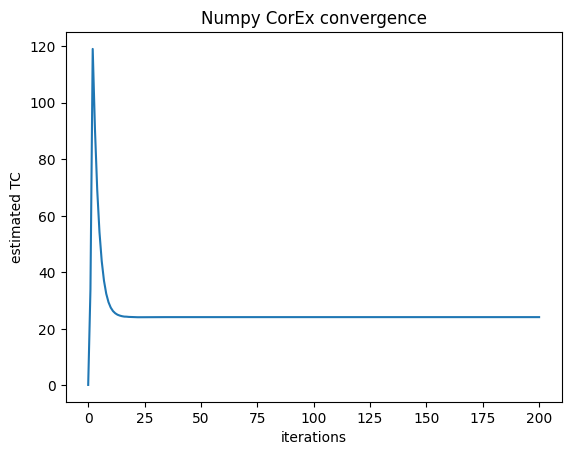

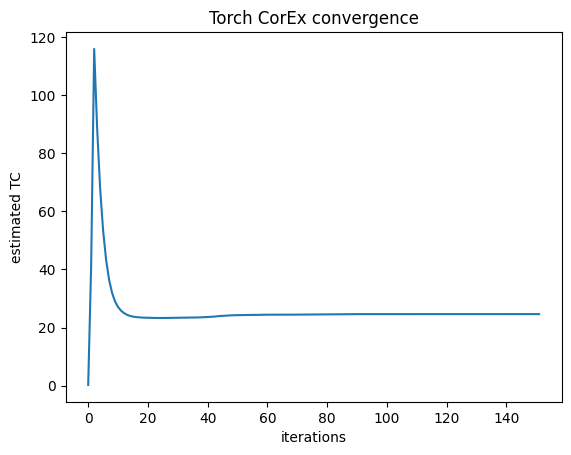

In [12]:
# Sanity check : convergence of TC values
plt.title("Numpy CorEx convergence")
plt.plot(corex_numpy.tc_history)
plt.xlabel("iterations")
plt.ylabel('estimated TC')
plt.show()

plt.title("Torch CorEx convergence")
plt.plot(corex_torch.tc_history)
plt.xlabel("iterations")
plt.ylabel('estimated TC')
plt.show()

## 3. Results

Explore the output of CorEx.  

In [15]:
# alpha correspond to the level associaiton of input variable with latent variable
alpha_ct = corex_torch.alpha.squeeze(-1)
cluster_ct = torch.argmax(alpha_ct,dim=0)
# output of corex is P(Z_j = 1 | X = x_sample)
# The table has shape of (number of Z_j, number of samples,categories of Z_j).
p_z_x = corex_torch.transform_proba(input)

In [14]:
# An example of visualization implementation. Only available for torch version for now
cv.plot_corex_with_vnames(corex_torch,col_names=data.index,)